<a href="https://colab.research.google.com/github/lnsayer/personal_repo/blob/main/drug%20discovery%20with%20BACE%20dataset/bace_dataset_going_modular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from IPython.display import Javascript


os.makedirs("going_modular", exist_ok=True)

In [2]:
print(os.getcwd())

/content


In [168]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


!pip install torch_geometric
!pip install deepchem

<IPython.core.display.Javascript object>

In [172]:
import os
import sys
import warnings
import tensorflow as tf
import logging
from deepchem.feat.graph_data import GraphData

# Suppress specific warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Suppress TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

# Redirect standard error output
sys.stderr = open(os.devnull, 'w')

# Configure logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

warnings.filterwarnings("ignore", message="os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.")
warnings.filterwarnings("ignore", category=RuntimeWarning)

# get_data.py

In [70]:
%%writefile going_modular/get_data.py
from timeit import default_timer as timer
import requests
from pathlib import Path
import pandas as pd
start_time()

# If want to download bace csv straight into colab
data_path = Path("going_modular/data/")
bace_path = data_path / "raw"

if bace_path.is_dir():
  print(f"{bace_path} is already a directory")
else:
  print(f"{bace_path} is not a directory, creating one")
  bace_path.mkdir(parents=True, exist_ok=True)

  with open(bace_path / "bace.csv", "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/lnsayer/personal_repo/main/drug%20discovery%20with%20BACE%20dataset/data/bace.csv")
    print("Downloading data")
    f.write(request.content)

# Resave the csv files without unnecessary columns
bace_df = pd.read_csv(bace_path/ "bace.csv")
bace_df = bace_df[["mol", "CID", "Class", "Model", "pIC50"]]
bace_df.to_csv(bace_path/"bace.csv")

bace_df
end_time()
print(f"get_data took {end_time - start_time:.4f}")

Overwriting going_modular/get_data.py


In [45]:
!python going_modular/get_data.py

going_modular/data/raw is already a directory


In [46]:
import pandas as pd
bace_df = pd.read_csv("going_modular/data/raw/bace.csv")
bace_df

,Unnamed: 0,mol,CID,Class,Model,pIC50
0,0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,BACE_1,1,Train,9.154901
1,1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,BACE_2,1,Train,8.853872
2,2,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_3,1,Train,8.698970
3,3,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,BACE_4,1,Train,8.698970
4,4,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_5,1,Train,8.698970
...,...,...,...,...,...,...
1508,1508,Clc1cc2nc(n(c2cc1)C(CC(=O)NCC1CCOCC1)CC)N,BACE_1543,0,Test,3.000000
1509,1509,Clc1cc2nc(n(c2cc1)C(CC(=O)NCc1ncccc1)CC)N,BACE_1544,0,Test,3.000000
1510,1510,Brc1cc(ccc1)C1CC1C=1N=C(N)N(C)C(=O)C=1,BACE_1545,0,Test,2.953115
1511,1511,O=C1N(C)C(=NC(=C1)C1CC1c1cc(ccc1)-c1ccccc1)N,BACE_1546,0,Test,2.733298


# data_setup.py

In [115]:
%%writefile going_modular/data_setup.py

from timeit import default_timer as timer
import_start_time = timer()
import subprocess
import torch
import torch_geometric
from torch_geometric.data import InMemoryDataset, Dataset, Data
from torch_geometric.loader import DataLoader
graphdata_start_time = timer()
from deepchem.feat.graph_data import GraphData
graphdata_end_time = timer()
graphdata_time = end_time-start_time
import os
import pandas as pd
import os.path as osp
import_end_time = timer()

data_setup_module_imports_time = import_end_time- import_start_time

# Custom torch geometric Dataset class to store the samples and their corresponding labels

class MoleculeDataset(Dataset):
  def __init__(self, root, csv_file, transform=None, pre_transform=None, pre_filter=None):
    """
    Constructor method of the class

    :root = Path where the dataset should be stored. This folder is split
    into raw_dir (downloaded dataset) and processed_dir(processed data).
    :csv_file = Desired name of the CSV file to be saved.
    : transform, pre_transform, pre_filter = optional transforms
    """
    self.csv_file = csv_file
    super().__init__(root, transform, pre_transform, pre_filter)

  @property
  def raw_file_names(self):
    """
    If this file exists in raw_dir, the download is not triggered/
    (the download function is not implemented here)
    """
    return self.csv_file

  @property
  def processed_file_names(self):
    """
    If these files are found in raw_dir, processing is skipped
    """
    self.data = pd.read_csv(self.raw_paths[0]).reset_index()

    return [f'data_{i}.pt' for i in list(self.data.index)]

  def download(self):
    """
    No need to download the csv file as it is already downloaded
    """
    pass

  def process(self):
    """
    Converts molecules with SMILES formats into PyTorch graphs. Uses Deepchem's MolGraphConvFeaturizer to create a graph
    and then convert that to a torch graph with to_pyg_graph. Saves these in the processed directory.
    """
    self.data = pd.read_csv(self.raw_paths[0]).reset_index()
    featurizer=dc.feat.MolGraphConvFeaturizer(use_edges=True)

    for idx, row in self.data.iterrows():
      # Featurize molecule and convert to torch graph
      smiles = row['mol']
      label = row['Class']
      pic50 = row['pIC50']

      out = featurizer.featurize(smiles)
      pyg_out = GraphData.to_pyg_graph(out[0])
      pyg_out.Class = torch.tensor([label])
      pyg_out.smiles = smiles
      pyg_out.pic50 = pic50

      # data = Data(x=pyg_out.x, edge_index=pyg_out.edge_index, edge_attr=pyg_out.edge_attr,
      #            y=torch.tensor([label]), dtype = torch.float)

      torch.save(pyg_out, osp.join(self.processed_dir, f'data_{idx}.pt'))

  def len(self):
    """
    Returns number of samples in the dataset
    """
    return len(self.processed_file_names)

  def get(self, idx):
    """
    Loads a single graph
    """
    data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
    return data

NUM_WORKERS = os.cpu_count()

def create_dataloaders(root_directory: str,
                       batch_size: int,
                       num_workers: int=NUM_WORKERS,
                       train_fraction: float=0.8):
  dataset = MoleculeDataset(root = root_directory, csv_file = "bace.csv").shuffle()

  train_indices = int(train_fraction*len(dataset))

  train_dataset = dataset[:train_indices]
  test_dataset = dataset[train_indices:]

  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

  return dataset, train_dataloader, test_dataloader


Overwriting going_modular/data_setup.py


# models.py

In [155]:
%%writefile going_modular/models.py

from timeit import default_timer as timer
import subprocess
import torch
import torch_geometric
from torch_geometric.nn import GCNConv, global_mean_pool, GraphConv, GATConv, MLP, GINConv, global_max_pool, SAGPooling, TopKPooling, GINEConv
from torch.nn import Linear, ReLU, Dropout, Softmax
import torch.nn as nn
import torch.nn.functional as F

#----------------------------------------------------------------------GCNClassifier----------------------------------------------------------------------


class GCNClassifier(torch.nn.Module):
  """
  Standard GCN graph classifier. Uses the graph convolutional operator from PyTorch geometric.
  """
  def __init__(self, in_channels:int, hidden_channels:int, out_channels:int, pool_method:torch_geometric.nn.pool):
    """
    :in_channels = number of features of the graph's nodes
    : hidden_channels = the number of hidden neurons in the network. The "width" of the network
    : out_channels = the number of output features, i.e 2 for classification.
    : pool_method = the pooling method to obtain graph embedding from node embedding.
    """
    super().__init__()
    # Convolutional Layers
    self.conv1 = GCNConv(in_channels, hidden_channels)

    self.conv2 = GCNConv(hidden_channels, hidden_channels)

    self.conv3 = GCNConv(hidden_channels, hidden_channels)

    # Linear layer used in classification
    self.lin = Linear(hidden_channels, out_channels)

    # Pooling method
    self.pool_method = pool_method

  def forward(self, data):
    """
    Forward pass of the network
    :data = the input data containing node features, edge indices, and batch information
    Returns probabilities of the two classes (drug/not drug)
    """

    # Obtain node embeddings
    x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr

    x = self.conv1(x, edge_index)
    x = F.leaky_relu(x)
    x = self.conv2(x, edge_index)
    x = F.leaky_relu(x)
    x = self.conv3(x, edge_index)

    # Aggregate node embeddings
    x = self.pool_method(x, batch)

    # Regularisation
    x = F.dropout(x)

    # Classification
    x = self.lin(x)

    x = F.softmax(x, dim=1)

    return x

class GraphConvClassifier(GCNClassifier):
  """
  Same architecture as GCN Classifier however uses GraphConv layers
  """
  def __init__(self, in_channels:int, hidden_channels:int, out_channels:int,  pool_method:torch_geometric.nn.pool):
    super().__init__(in_channels, hidden_channels, out_channels, pool_method)
    self.conv1 = GraphConv(in_channels, hidden_channels)

    self.conv2 = GraphConv(hidden_channels, hidden_channels)

    self.conv3 = GraphConv(hidden_channels, hidden_channels)

    self.pool_method = pool_method

#------------------------------------------------------------------GATCLassifier------------------------------------------------------------------


class GATClassifier(torch.nn.Module):
  """
  GAT Convolutional graph classifier. Uses the graph attention operator from PyTorch geometric
  """
  def __init__(self, in_channels:int, hidden_channels:int, out_channels:int, heads:int, pool_method:torch_geometric.nn.pool,
               use_edge_attr:bool):
    """
    :in_channels = number of features of the graph's nodes.
    : hidden_channels = the number of hidden neurons in the network. The "width" of the network.
    : out_channels = the number of output features, i.e 2 for classification.
    : heads = the number of multi-headed attentions.
    : pool_method = the pooling method to obtain graph embedding from node embedding.
    : use_edge_attr = boolean variable which determines whether to use the edge attributes of the graph.
    """
    super().__init__()
    # Convolutional Layers
    self.conv1 = GATConv(in_channels,
                         hidden_channels,
                         heads,
                         concat = True)
    self.conv2 = GATConv(hidden_channels*heads,
                         hidden_channels,
                         heads,
                         concat=True)
    self.conv3 = GATConv(hidden_channels*heads,
                         hidden_channels,
                         1,
                         concat=False)
    self.lin = Linear(hidden_channels, out_channels)

    # Pooling method
    self.pool_method = pool_method

  def forward(self, data):
    """
    Forward pass of the network
    :data = the input data containing node features, edge indices, and batch information
    Returns probabilities of the two classes (drug/not drug)
    """

    # Obtain node embeddings
    x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr

    # can use edge attributes
    if use_edge_attr:
      x = self.conv1(x, edge_index, edge_attr)
      x = F.leaky_relu(x)
      x = self.conv2(x, edge_index, edge_attr)
      x = F.leaky_relu(x)
      x = self.conv3(x, edge_index, edge_attr)

    # not using edge attributes
    else:
      x = self.conv1(x, edge_index)
      x = F.leaky_relu(x)
      x = self.conv2(x, edge_index)
      x = F.leaky_relu(x)
      x = self.conv3(x, edge_index)

    # Aggregate node embeddings
    x = self.pool_method(x, batch)

    # Regularisation
    x = F.dropout(x)

    # Classification
    x = self.lin(x)

    x = F.softmax(x, dim=1)

    return x

#-------------------------------------------------------------------GINConvClassifier-------------------------------------------------------------------

class GINConvClassifier(torch.nn.Module):
  """
  Applies the graph isomorphism operator
  """
  def __init__(self, in_channels, hidden_channels, out_channels, num_layers, pool_method: torch_geometric.nn.pool):
    """
    Constructor method
    :in_channels = number of features of the graph's nodes
    : hidden_channels = the number of hidden neurons in the network. The "width" of the network
    : out_channels = the number of output features, i.e 2 for classification.
    : num_layers = the number of layers of the multi-layer perceptron
    : pool_method = the pooling method to obtain graph embedding from node embedding.
    """

    super().__init__()

    self.convs = torch.nn.ModuleList()
    self.conv = GINConv
    self.pool_method = pool_method

    # Create multiple GINConv layers as specified by num_layers
    for _ in range(num_layers):
      mlp = MLP([in_channels, hidden_channels, hidden_channels])
      self.convs.append(self.conv(nn=mlp, train_eps=False))
      in_channels = hidden_channels

    # Define the final MLP
    self.mlp = MLP([hidden_channels, hidden_channels, out_channels], norm = None, dropout = 0.5)

  def forward(self, data):
    """
    Forward pass of the network
    :data = the input data containing node features, edge indices, and batch information
    Returns probabilities of the two classes (drug/not drug)
    """
    x, edge_index, batch = data.x, data.edge_index, data.batch
    for conv in self.convs:
      x = conv(x, edge_index).relu()
    x = self.pool_method(x, batch)
    return self.mlp(x)

#----------------------------------------------------------------------GINEConvClassifier----------------------------------------------------------------------

class GINEConvClassifier(torch.nn.Module):
  """
  Same as the GINConvClassifier, however also uses edge attributes of the graphs
  """
  def __init__(self, in_channels, hidden_channels, out_channels, num_layers, pool_method: torch_geometric.nn.pool,
               use_edge_attr:bool, edge_dim:int):
    """
    Constructor method
    :in_channels = number of features of the graph's nodes
    : hidden_channels = the number of hidden neurons in the network. The "width" of the network
    : out_channels = the number of output features, i.e 2 for classification.
    : num_layers = the number of layers of the multi-layer perceptron
    : pool_method = the pooling method to obtain graph embedding from node embedding.
    : use_edge_attr = boolean variable to determine whether will use the edge attributes or not.
    : edge_dim = the dimensionality of the edge attributes for the graph's edges
    """
    super().__init__()

    self.convs = torch.nn.ModuleList()
    self.conv = GINEConv
    self.pool_method = pool_method
    self.use_edge_attr = use_edge_attr
    self.edge_dim = edge_dim

    for _ in range(num_layers):
      mlp = MLP([in_channels, hidden_channels, hidden_channels])
      self.convs.append(self.conv(nn=mlp, train_eps=False, edge_dim=self.edge_dim))
      in_channels = hidden_channels

    self.mlp = MLP([hidden_channels, hidden_channels, out_channels], norm = None, dropout = 0.5)

  def forward(self, data):
    """
    Forward pass of the network
    :data = the input data containing node features, edge indices, and batch information
    Returns probabilities of the two classes (drug/not drug)
    """
    x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr
    for conv in self.convs:
      if self.use_edge_attr:
        x = conv(x, edge_index, edge_attr).relu()
      else:
        x = conv(x, edge_index).relu()

    x = self.pool_method(x, batch)
    return self.mlp(x)



Overwriting going_modular/models.py


# engine.py

In [149]:
%%writefile going_modular/engine.py

import torch
from sklearn.metrics import roc_auc_score
from pathlib import Path
from typing import Callable, Optional, Any
import pickle
from torch_geometric.nn import global_mean_pool
from tqdm.auto import tqdm
from timeit import default_timer as timer


#--------------------------------------------------------------------train_step--------------------------------------------------------------------

def train_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  """
  Performs the training of a model for one epoch for the training dataloader.

  Returns lists of the training loss, accuracy and AUC of the training dataloader for the epoch.
  """

  model.to(device)
  model.train()

  train_loss, train_acc, train_auc = 0, 0, 0

  # We time how long it takes for each section in the training process
  auc_time = 0
  out_time = 0
  loss_time = 0
  optimizer_time = 0
  section_time = 0
  dataloader_loop_time = 0
  inside_loop_time = 0


  loop_start_time = timer()

  # Loop over the batches
  for idx, batch in enumerate(dataloader):
    # print(f"entered {idx} loop of train step")
    inside_loop_start_time = timer()
    # Time how long it takes to obtain an idx and batch of the dataloader
    if idx > 1:
      dataloader_loop_end_time = timer()
      dataloader_loop_time += dataloader_loop_end_time-dataloader_loop_start_time

    # Can time how long any chosen section takes to run
    section_start_time = timer()
    to_device_start_time = timer()
    batch = batch.to(device)
    to_device_end_time = timer()

    # Optimizer zero grad
    optimizer.zero_grad()

    # Forward pass
    out_start_time = timer()
    out = model(batch)
    out_end_time = timer()
    out_time+=out_end_time-out_start_time

    # Calculate the loss
    loss = loss_fn(out, batch.Class)
    train_loss += loss.item()

    # Calculate the label predictions
    label_preds = torch.argmax(out, dim=1)
    # Calculate accuracy
    train_acc += (label_preds == batch.Class).sum()

    # Calculate AUC
    auc_start_time = timer()
    # Check both classes present in batch.Class, otherwise add the batch_auc from the previous iteration
    if len(torch.unique(batch.Class)) == 2:
        batch_auc = roc_auc_score(batch.Class.detach().cpu().numpy(), out[:,1].detach().cpu().numpy())
        train_auc += batch_auc
    else:
      train_auc += batch_auc

    auc_end_time = timer()
    auc_time += auc_end_time-auc_start_time


    # Loss backward
    loss_start_time = timer()
    loss.backward()
    loss_end_time = timer()
    loss_time += loss_end_time-loss_start_time

    # Optimizer step
    optimizer_start_time = timer()
    optimizer.step()
    optimizer_end_time = timer()
    optimizer_time = optimizer_end_time-optimizer_start_time
    section_end_time = timer()
    section_time+=section_end_time-section_start_time
    dataloader_loop_start_time = timer()
    inside_loop_end_time = timer()
    inside_loop_time += inside_loop_end_time-inside_loop_start_time


  loop_end_time = timer()
  # print(f"Section time is {section_time:.4f}")
  # print(f"Dataloader loop time is {dataloader_loop_time:.4f}")

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss/len(dataloader.dataset)
  train_acc = train_acc/len(dataloader.dataset)
  train_auc = train_auc/len(dataloader)
  # print(f"AUC calculation time: {auc_time:.4f}s, Forward pass: {out_time:.4f}s, Loss time: {loss_time:.4f}, Optimizer time: {optimizer_time:.4f}, To device time: {to_device_end_time-to_device_start_time:.4f}\n")


  #print(f"Train outside loop time is {loop_end_time-loop_start_time:.4f}, inside loop time is {inside_loop_time:.4f}")

  return train_loss, train_acc, train_auc

#--------------------------------------------------------------------test_step------------------------------------------------------------------------

def test_step(model:torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device: torch.device):

  """
  Performs the testing of a model for one epoch for the test dataloader.

  Returns lists of the test loss, accuracy and AUC of the test dataloader for the epoch.
  """

  # Put model in eval mode
  model.eval()

  test_loss, test_acc, test_auc = 0, 0, 0

  # Turn on torch inference manager
  with torch.inference_mode():
    # Loop through data batches
    for idx, batch in enumerate(dataloader):
      # print(f"entered test step {idx} batch loop")
      batch = batch.to(device)

      # Forward pass
      out = model(batch)

      # Calculate the loss
      loss = loss_fn(out, batch.Class)
      test_loss += loss.item()

      # Calculate the label predictions
      label_preds = torch.argmax(out, dim=1)
      # Calculate accuracy
      test_acc += (label_preds == batch.Class).sum()/len(label_preds)

      # Calculate the AUC
      if len(torch.unique(batch.Class)) == 2:
        batch_auc = roc_auc_score(batch.Class.detach().cpu().numpy(), out[:,1].detach().cpu().numpy())
        test_auc += batch_auc
      else:
        test_auc += batch_auc


    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)
    test_auc = test_auc/len(dataloader)

    return test_loss, test_acc, test_auc

#--------------------------------------------------------------------moving_average--------------------------------------------------------------------

def moving_average(values:list , window_size:int):
    """
    Calculates the simple moving average of the last window_size elements in a list of values

    Returns the average
    """
    if len(values) < window_size:
        return None
    return sum(values[-window_size:]) / window_size


#--------------------------------------------------------------------train-----------------------------------------------------------------------------

def train(model: torch.nn.Module,
          device: torch.device,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(),
          epochs: int =5,
          model_save_path: str = None,
          window_size: int=10,
          patience: int=10):
  """
  Combines train_step and test_step to train a model and evaluate it at each epoch on the train_dataloader and test_dataloader.

  :model_save_path = a string used to save the model's parameters. If no string is provided it is not saved.

  Returns a dictionary of results.
  """


  # 1. Create empty results dictionary
  results = {"epoch": [],
             "train_loss": [],
             "train_acc": [],
             "train_auc": [],
             "test_loss": [],
             "test_acc": [],
             "test_auc": [],
             "saved_epochs": [],
             "test_loss_mov_avg": [],
             "test_auc_mov_avg": []}
  # 2. Loop through training and testing steps for a number of epochs
  best_moving_loss_avg = float('inf')
  best_moving_auc_avg = 0

  # Loop over the number of epochs
  for i in tqdm(range(epochs)):

    start_time = timer()
    train_step_start_time = timer()
    train_loss, train_acc, train_auc = train_step(model,
                                       train_dataloader,
                                       loss_fn,
                                       optimizer,
                                       device)
    train_step_end_time = timer()
    test_step_start_time = timer()
    test_loss, test_acc, test_auc = test_step(model,
                                    test_dataloader,
                                    loss_fn,
                                    optimizer,
                                    device)
    test_step_end_time = timer()
    # print(f"Train step time is {train_step_end_time-train_step_start_time:.4f}s, Test step time is {test_step_end_time-test_step_start_time:.4f}s\n")

    # 3. Print out what's happening
    print(f"Epoch: {i}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Train AUC: {train_auc:.4f}, Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}, Test auc: {test_auc:.4f}")
    # 4. Update results dictionary
    append_start_time = timer()
    results["epoch"].append(i)
    results["train_loss"].append(round(train_loss, 4))
    results["train_acc"].append(round(train_acc.item(), 4))
    results["train_auc"].append(round(train_auc, 4))
    results["test_loss"].append(round(test_loss, 4))
    results["test_acc"].append(round(test_acc.item(), 4))
    results["test_auc"].append(round(test_auc, 4))
    append_end_time = timer()
    # print(f"append time is{append_end_time-append_start_time:.4f}")

    # 5. If model_save_path provided, save the model to its path based on whether test loss and test AUC have improved.
    """
    Once the number of epochs is greater than the window_size a current moving average is created of the last 'window_size'
    loss and AUC values. As long as these current metrics are higher than the current moving average, the model is saved.
    If the current metrics are not better than the current moving average for 'patience' epochs the training stops early.
    """

    save_timer_start = timer()
    if model_save_path:
      current_moving_loss_avg = moving_average(results["test_loss"], window_size)
      if current_moving_loss_avg is not None:
        results["test_loss_mov_avg"].append(round(current_moving_loss_avg, 4))
      else:
        results["test_loss_mov_avg"].append(None)


      current_moving_auc_avg = moving_average(results["test_auc"], window_size)
      if current_moving_auc_avg is not None:
        results["test_auc_mov_avg"].append(round(current_moving_auc_avg, 4))
      else:
        results["test_auc_mov_avg"].append(None)

      if current_moving_loss_avg is not None and current_moving_auc_avg is not None:
        if current_moving_loss_avg < best_moving_loss_avg and current_moving_auc_avg > best_moving_auc_avg:
          without_improvement_count = 0
          results["saved_epochs"].append(i)
          torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
                   f=model_save_path)
          print(f"Saved model at epoch {i} with current average test loss: {current_moving_loss_avg:.4f} and previous best: {best_moving_loss_avg:.4f}")
          print(f"Saved model at epoch {i} with current average AUC loss: {current_moving_auc_avg:.4f} and previous best: {best_moving_auc_avg:.4f}")
          best_moving_loss_avg = current_moving_loss_avg
          best_moving_auc_avg = current_moving_auc_avg

        else:
          without_improvement_count += 1
          print(f"Without_improvement_count: {without_improvement_count}")
        if without_improvement_count > patience:
          print("Early Stopping")
          break
    save_timer_end = timer()
    end_time  = timer()
    print(f"Epoch took {end_time-start_time:.2f} seconds")
    # print(f"Time to save loop : {save_timer_end-save_timer_start:.4f}")

  # 6. Return the filled results at the end of the epochs

  return results

#---------------------------------------------------------------------run_model_repeats---------------------------------------------------------------------

def run_model_repeats(model: torch.nn.Module,
                      device: torch.device,
                      train_dataloader: torch.utils.data.DataLoader,
                      test_dataloader: torch.utils.data.DataLoader,
                      optimizer_: Callable[[], torch.optim.Optimizer],
                      criterion: torch.nn.Module,
                      models_directory: Path=None,
                      num_hidden_channels: int = 128,
                      pool_method: Any = global_mean_pool,
                      nb_epochs: int = 300,
                      nb_repeats: int = 1,
                      window_size: int = 10,
                      patience: int = 50):
  """
  Runs training runs for 'nb_repeats' and optionally saves them if nb_repeats.
  Optionally save the model and its results if models_directory provided.
  """

  for i in range(nb_repeats):
    if models_directory:
      model_save_name = f"{i}_{num_hidden_channels}_{nb_epochs}_{pool_method.__name__}.pth"
      model_save_path  = models_directory / model_save_name
    else:
      model_save_path = None
    optimizer = optimizer_(model.parameters())


    results = train(model,
        device,
        train_dataloader,
        test_dataloader,
        optimizer,
        criterion,
        epochs = nb_epochs,
        model_save_path = model_save_path,
        window_size=window_size,
        patience=patience)
    if models_directory:
      with open(models_directory/f"{i}_{num_hidden_channels}_{nb_epochs}_{pool_method.__name__}_results.pkl", 'wb') as f:
        print("Saved results of this model")
        pickle.dump(results, f)
    else:
      print("Did not save results of this model")



Overwriting going_modular/engine.py


# utils.py

In [138]:
%%writefile going_modular/utils.py

import torch
import pandas as pd
from sklearn.metrics import classification_report
from pathlib import Path

#------------------------------------------------------------adam_optimizer_callable------------------------------------------------------------


def adam_optimizer_callable(parameters, lr=0.001, weight_decay=0):
    return torch.optim.Adam(parameters, lr=lr, weight_decay=weight_decay)

#-----------------------------------------------------------------new_metric_func-----------------------------------------------------------------


def new_metric_func(model, train_dataset, test_dataset, train_dataloader, test_dataloader):
  """
  Calculates the metrics (AUC and Scikit-Learn's Classification report metrics) for a model for its training data and test data.

  Returns training and test AUROC curve and training and test Sklearn classification report as a dataframe
  """
  with torch.inference_mode():
    model.eval()

    # Create empty tensors to fill with probabilities, predictions and labels
    total_train_probs = torch.empty(len(train_dataset))
    total_train_preds = torch.empty(len(train_dataset))
    total_train_labels = torch.empty(len(train_dataset))

    total_test_probs = torch.empty(len(test_dataset))
    total_test_preds = torch.empty(len(test_dataset))
    total_test_labels = torch.empty(len(test_dataset))

    # Loop over batches and add to the total tensors

    for idx, batch in enumerate(train_dataloader):
      batch = batch.to(device)
      batch_size = 32
      current_batch_size = len(batch)
      # print(f"{idx*batch_size}:{idx*batch_size+current_batch_size}")
      out = model.forward(batch)
      train_probs = out[:,1]
      train_preds = torch.argmax(out, dim=1)

      total_train_probs[idx*batch_size:idx*batch_size+current_batch_size] = train_probs
      total_train_preds[idx*batch_size:idx*batch_size+current_batch_size] = train_preds
      total_train_labels[idx*batch_size:idx*batch_size+current_batch_size] = batch.Class

    for idx, batch in enumerate(test_dataloader):
      batch = batch.to(device)
      batch_size = 32
      current_batch_size = len(batch)
      # print(f"{idx*batch_size}:{idx*batch_size+current_batch_size}")
      out = model.forward(batch)
      test_probs = out[:,1]
      test_preds = torch.argmax(out, dim=1)

      total_test_probs[idx*batch_size:idx*batch_size+current_batch_size] = test_probs
      total_test_preds[idx*batch_size:idx*batch_size+current_batch_size] = test_preds
      total_test_labels[idx*batch_size:idx*batch_size+current_batch_size] = batch.Class

    # Calculate AUC and dataframes of metrics (using Scikit-Learn's metrics)
    train_auroc = roc_auc_score(total_train_labels, total_train_probs).item()
    train_classification_report = classification_report(total_train_labels, total_train_preds, output_dict=True)
    train_report_df = pd.DataFrame(data=train_classification_report).transpose()

    test_auroc = roc_auc_score(total_test_labels, total_test_probs).item()
    test_classification_report = classification_report(total_test_labels, total_test_preds, output_dict=True)
    test_report_df = pd.DataFrame(data=test_classification_report).transpose()


  return train_auroc, test_auroc, train_report_df, test_report_df

#---------------------------------------------------------------average_model_metrics---------------------------------------------------------------

def average_model_metrics(model: torch.nn.Module,
                          models_directory: Path,
                          model_name_stem: str,
                          repeats: int,
                          save_yes_no: bool):
  """
  Takes a GNN model architecture and a directory where its weights are stored (repeats) then return an average of their performance metrics.
  Uses new_metric_func

  :model = instance of a classification model which will load the model parameters of trained models
  :model_directory = directory where the model parameters are stored
  : model_name_stem = name stem of the repeats e.g. "_128_300_global_mean_pool.pth"
  : repeats = number of repeats in the directory
  : save_yes_no = option to save the results as pickle files in the same directory

  Returns dataframes of the mean and stadndard deviation of the training and test performance metrics (AUROC, Sklearn metrics).
  """
  # Will append results of each model's performance to these lists (AUROC and classification report metric)
  train_auroc_list = []
  test_auroc_list = []
  train_report_list = []
  test_report_list = []

  # Loop over the number of repeats of the model runs
  for i in range(repeats):
    model_name = f"{i}" + model_name_stem
    model_path = models_directory / model_name
    model.load_state_dict(torch.load(f=model_path))
    model.to(device)
    train_auroc, test_auroc, train_classification_report, test_classification_report = new_metric_func(model, train_dataloader, test_dataloader)
    train_auroc_list.append(train_auroc)
    test_auroc_list.append(test_auroc)
    train_report_list.append(pd.DataFrame(train_classification_report))
    test_report_list.append(pd.DataFrame(test_classification_report))

  # Calculate averages and standard deviations of our repeats
  mean_train_auroc = np.mean(train_auroc_list)
  mean_test_auroc = np.mean(test_auroc_list)

  std_train_auroc = np.std(train_auroc_list)
  std_test_auroc = np.std(test_auroc_list)

  auroc_data = {"Train": [mean_train_auroc, std_train_auroc],
               "Test": [mean_test_auroc, std_test_auroc]}
  auroc_df = pd.DataFrame(auroc_data)


  mean_train_model_metrics = pd.DataFrame(pd.concat(train_report_list).groupby(level=0).mean())
  mean_test_model_metrics = pd.DataFrame(pd.concat(test_report_list).groupby(level=0).mean())

  std_train_model_metrics = pd.DataFrame(pd.concat(train_report_list).groupby(level=0).std())
  std_test_model_metrics = pd.DataFrame(pd.concat(test_report_list).groupby(level=0).std())

  # Option to save the results as pickle files (which can later be loaded and turned into dataframes)
  if save_yes_no:

    with open(models_directory/f"{num_hidden_channels}_{nb_epochs}_{pool_method.__name__}_auroc_df.pkl", 'wb') as f:
      print("Saved auroc dataframe")
      pickle.dump(auroc_df, f)

    with open(models_directory/f"{num_hidden_channels}_{nb_epochs}_{pool_method.__name__}_mean_train_metrics.pkl", 'wb') as f:
      print("Saved mean train metrics")
      pickle.dump(mean_train_model_metrics, f)

    with open(models_directory/f"{num_hidden_channels}_{nb_epochs}_{pool_method.__name__}_mean_test_metrics.pkl", 'wb') as f:
      print("Saved mean test metrics")
      pickle.dump(mean_test_model_metrics, f)

    with open(models_directory/f"{num_hidden_channels}_{nb_epochs}_{pool_method.__name__}_std_train_metrics.pkl", 'wb') as f:
      print("Saved std train metrics")
      pickle.dump(std_train_model_metrics, f)

    with open(models_directory/f"{num_hidden_channels}_{nb_epochs}_{pool_method.__name__}_std_test_metrics.pkl", 'wb') as f:
      print("Saved std test metrics")
      pickle.dump(std_test_model_metrics, f)


  return auroc_df, mean_train_model_metrics, mean_test_model_metrics, std_train_model_metrics, std_test_model_metrics

#---------------------------------------------------------------loss_acc_auc_plots---------------------------------------------------------------


def loss_acc_auc_plots(results:dict):
  """
  Plots the loss, accuracy metric and AUCROC metric curves of the training and test set of a model results (dictionary).

  Returns three plots.
  """

  fig, ax = plt.subplots(ncols=3, nrows=1, figsize = (15,6))

  ax[0].plot(results["epoch"], results["train_loss"], label="Train");
  ax[0].plot(results["epoch"], results["test_loss"],  label="Test");
  ax[0].vlines(results["saved_epochs"], ymin=0, ymax = max(results["test_loss"]), alpha=0.2, colors='black', linestyle='dashed', label = 'Saved epochs')

  ax[1].plot(results["epoch"], results["train_acc"], label="Train");
  ax[1].plot(results["epoch"], results["test_acc"],  label="Test");
  ax[1].vlines(results["saved_epochs"], ymin=0, ymax = max(results["train_acc"]), alpha=0.2, colors='black', linestyle='dashed', label = 'Saved epochs')

  ax[2].plot(results["epoch"], results["train_auc"], label="Train");
  ax[2].plot(results["epoch"], results["test_auc"],  label="Test");
  ax[2].vlines(results["saved_epochs"], ymin=0, ymax = max(results["train_auc"]), alpha=0.2, colors='black', linestyle='dashed', label = 'Saved epochs')

  ax[0].set_xlabel("Epochs", size=14)
  ax[0].set_ylabel("Loss", size=14)

  ax[1].set_xlabel("Epochs", size=14)
  ax[1].set_ylabel("Accuracy", size=14)

  ax[2].set_xlabel("Epochs", size=14)
  ax[2].set_ylabel("AUC", size=14)

  ax[0].legend();
  ax[1].legend();
  ax[2].legend();

Overwriting going_modular/utils.py


# train.py

In [176]:
%%writefile going_modular/train.py
from timeit import default_timer as timer

total_import_time_start = timer()
start_time = timer()
import torch
from torch_geometric.nn import global_mean_pool
end_time = timer()
print(f"torch, torch_geometric.nn took {end_time-start_time:.4f}")

start_time = timer()
import data_setup
from data_setup import *
end_time = timer()
print(f"Imported data_setup.py, took {end_time - start_time:.4f}")

start_time = timer()
import models
from models import *
end_time = timer()
print(f"Imported models.py, took {end_time - start_time:.4f}")

start_time = timer()
import engine
from engine import *
end_time = timer()
print(f"Imported engine.py, took {end_time - start_time:.4f}")

start_time = timer()
import utils
from utils import *
end_time = timer()
print(f"Imported utils.py, took {end_time-start_time:.4f}")

total_import_time_end = timer()

start_time = timer()
dataset, train_dataloader, test_dataloader = create_dataloaders(root_directory = "going_modular/data/",
                                                                batch_size = 32)
end_time = timer()




print("-------------------------------------------------------------------------------------------------------------------------------------------------")

print(f"time to import modules in data_setup.py: {data_setup_module_imports_time}")
print(f"time to import graphdata in data_setup.py: {graphdata_time}")
print(f"Total import time: {total_import_time_end - total_import_time_start}")

print(f"Created dataset, train_dataloader, test_dataloader, took {end_time - start_time:.4f}s")

num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 128
num_out_channels = 2
pool_method = global_mean_pool
criterion = torch.nn.CrossEntropyLoss()


device = "cuda" if torch.cuda.is_available() else "cpu"
bace_models_path = Path("drive/MyDrive/bace_graph_project/models")
bace_gcn_models_path = bace_models_path / "gcn_models"

run_model_repeats(model = GCNClassifier(num_features, num_hidden_channels, num_out_channels, global_mean_pool),
                  device = device,
                  train_dataloader = train_dataloader,
                  test_dataloader = test_dataloader,
                  optimizer_ = adam_optimizer_callable,
                  criterion = torch.nn.CrossEntropyLoss(),
                  models_directory = None,
                  num_hidden_channels = 128,
                  pool_method = global_mean_pool,
                  nb_epochs = 5,
                  nb_repeats = 1,
                  window_size = 10,
                  patience = 50)



Overwriting going_modular/train.py


# Run train.py

In [177]:
from IPython.display import Javascript
from timeit import default_timer as timer


display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
warnings.simplefilter("ignore", RuntimeWarning)



start_time = timer()
!python going_modular/train.py
end_time = timer()
print(f"Time to run train.py: {end_time-start_time:.4f}")

<IPython.core.display.Javascript object>

torch, torch_geometric.nn took 3.3507
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'haiku'
Imported data_setup.py, took 7.8819
Imported models.py, took 0.0004
Imported engine.py, took 0.0005
Imported utils.py, took 0.0003
-------------------------------------------------------------------------------------------------------------------------------------------------
time to import modules in data_setup.py: 7.881839334999313
time to import graphdata in data_setup.py: 7.881817170000431
Total import time: 11.234199897999133
Created dataset, train_dataloader, test_dataloader

In [210]:
import matplotlib.pyplot as plt

def loss_acc_auc_plots(results:dict):
  """
  Plots the loss, accuracy metric and AUCROC metric curves of the training and test set of a model results (dictionary).

  Returns three plots.
  """

  fig, ax = plt.subplots(ncols=3, nrows=1, figsize = (15,6))

  ax[0].plot(results["epoch"], results["train_loss"], label="Train");
  ax[0].plot(results["epoch"], results["test_loss"],  label="Test");
  ax[0].vlines(results["saved_epochs"], ymin=0, ymax = max(results["test_loss"]), alpha=0.2, colors='black', linestyle='dashed', label = 'Saved epochs')

  ax[1].plot(results["epoch"], results["train_acc"], label="Train");
  ax[1].plot(results["epoch"], results["test_acc"],  label="Test");
  ax[1].vlines(results["saved_epochs"], ymin=0, ymax = max(results["train_acc"]), alpha=0.2, colors='black', linestyle='dashed', label = 'Saved epochs')

  ax[2].plot(results["epoch"], results["train_auc"], label="Train");
  ax[2].plot(results["epoch"], results["test_auc"],  label="Test");
  ax[2].vlines(results["saved_epochs"], ymin=0, ymax = max(results["train_auc"]), alpha=0.2, colors='black', linestyle='dashed', label = 'Saved epochs')

  ax[0].set_xlabel("Epochs", size=14)
  ax[0].set_ylabel("Loss", size=14)

  ax[1].set_xlabel("Epochs", size=14)
  ax[1].set_ylabel("Accuracy", size=14)

  ax[2].set_xlabel("Epochs", size=14)
  ax[2].set_ylabel("AUC", size=14)

  ax[0].legend();
  ax[1].legend();
  ax[2].legend();


0


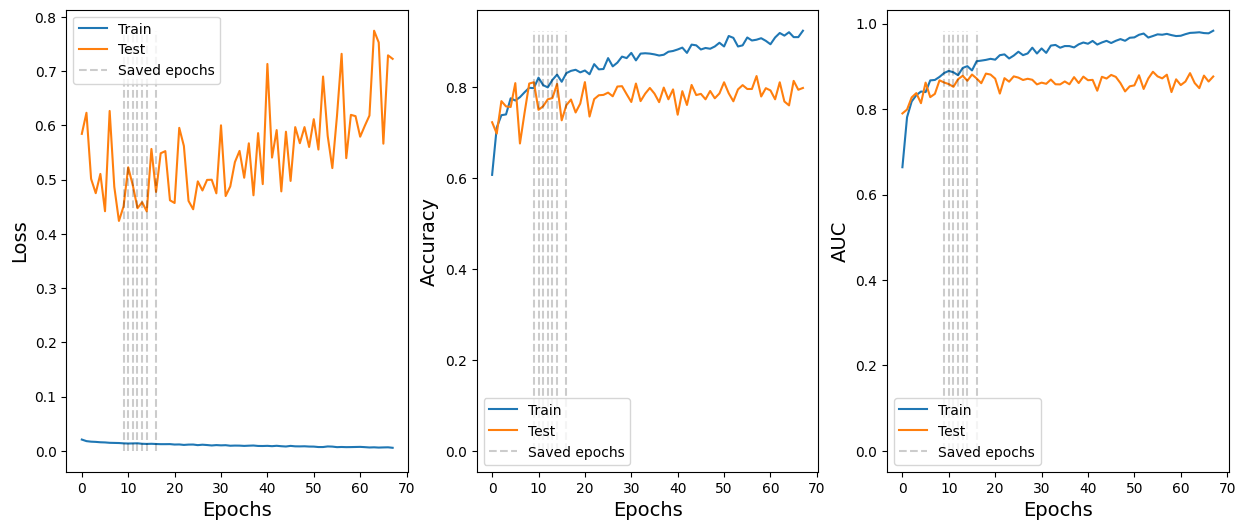

1


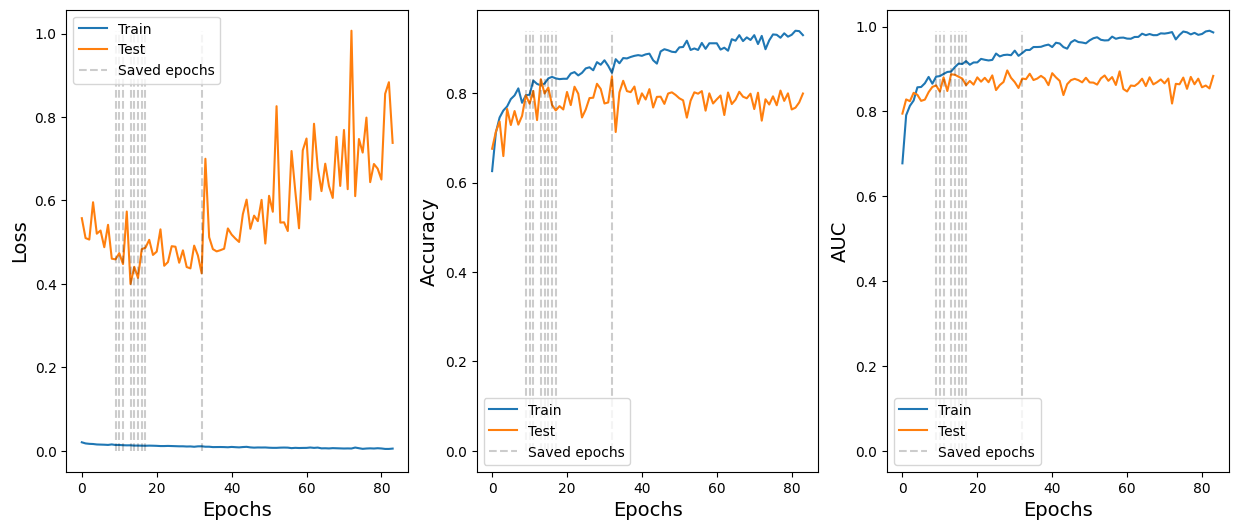

2


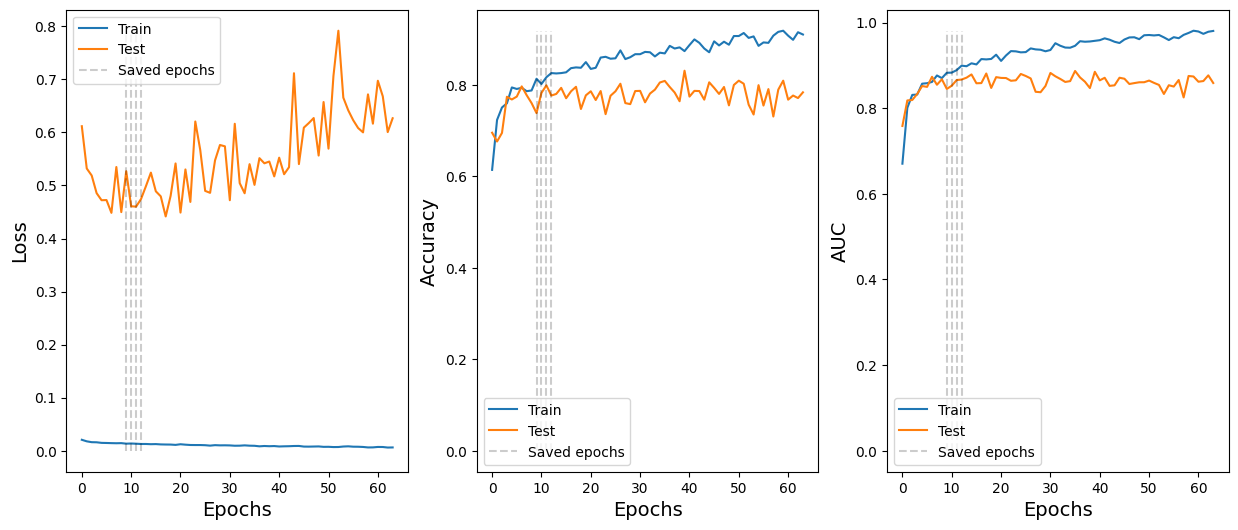

3


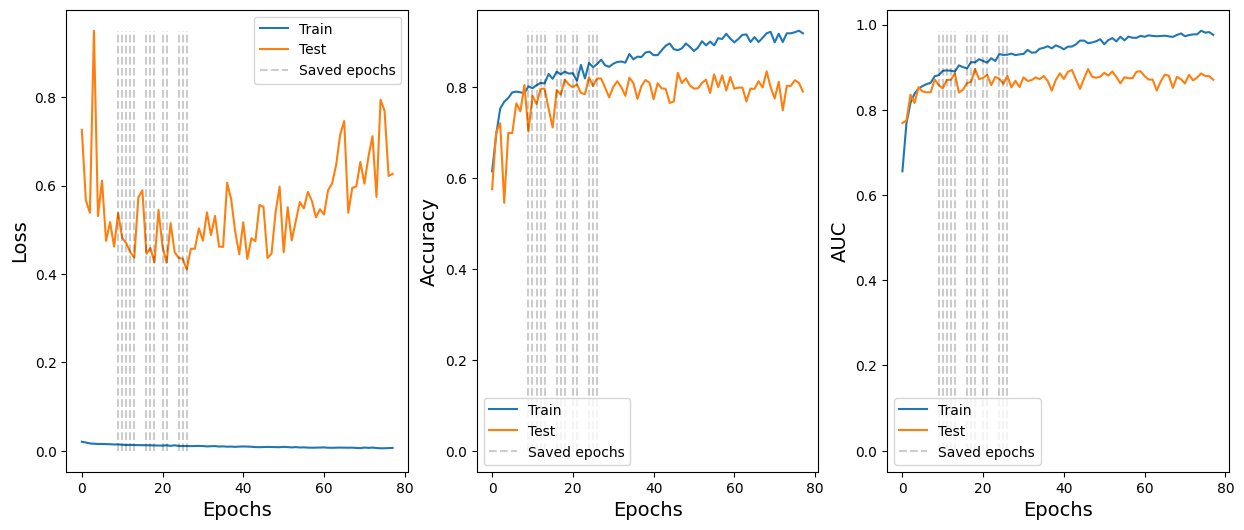

4


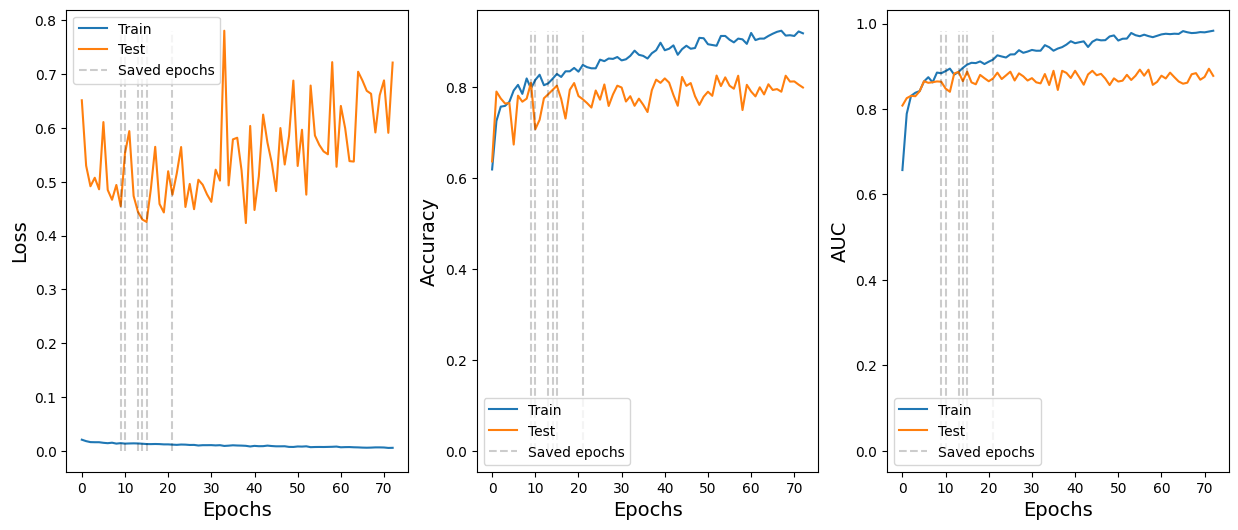

In [211]:
from timeit import default_timer as timer

import pickle
import matplotlib.pyplot as plt

for i in range(0,5):
  print(i)
  with open(f'/content/drive/MyDrive/bace_graph_project/models/ginconv_models/{i}_128_300_global_mean_pool_results.pkl', 'rb') as func:
      loaded_dict = pickle.load(func)

  loss_acc_auc_plots(loaded_dict)
  plt.show()